# Intro

[Self-Consistency Improves Chain of Thought Reasoning in Language Models](https://arxiv.org/abs/2203.11171)
Xuezhi Wang, Jason Wei, Dale Schuurmans, Quoc Le, Ed Chi, Sharan Narang, Aakanksha Chowdhery, Denny Zhou
2022

Based on chain-of-thought prompt. Examples in prompt show the pattern of "Here's my reasoning. The answer is \_\_\_."

They use different prompts for different benchmark challenges (some are about math, some verbal). Most come from another chain-of-thought paper, [Wei et al. 2022 - Chain-of-Thought Prompting Elicits Reasoning in Large Language Models](https://arxiv.org/abs/2201.11903)

<img src="images/self_consistency/prompt_example_for_text_answers.png" height="250"/>

We'll use this example, which also comes from the paper, focused on arithmetic reasoning. 

In [1]:
few_shot_prompt='''Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there will be 21 trees. How many trees did the grove workers plant today?
A: There are 15 trees originally. Then there were 21 trees after some more were planted. So there must have been 21 - 15 = 6. The answer is 6.
Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
A: There are originally 3 cars. 2 more cars arrive. 3 + 2 = 5. The answer is 5.
Q: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
A: Originally, Leah had 32 chocolates. Her sister had 42. So in total they had 32 + 42 = 74. After eating 35, theyhad 74 - 35 = 39. The answer is 39.
Q: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did Jason give to Denny?
A: Jason started with 20 lollipops. Then he had 12 after giving some to Denny. So he gave Denny 20 - 12 = 8. The answer is 8.
Q: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does he have now?
A: Shawn started with 5 toys. If he got 2 toys each from his mom and dad, then that is 4 more toys. 5 + 4 = 9. The answer is 9.
Q: There were nine computers in the server room. Five more computers were installed each day, from monday to thursday. How many computers are now in the server room?
A: There were originally 9 computers. For each of 4 days, 5 more computers were added. So 5 * 4 = 20 computers were added. 9 + 20 is 29. The answer is 29.
Q: Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many golf balls did he have at the end of wednesday?
A: Michael started with 58 golf balls. After losing 23 on tuesday, he had 58 - 23 = 35. After losing 2 more, he had 35 - 2 = 33 golf balls. The answer is 33.
Q: Olivia has $23. She bought five bagels for $3 each. How much money does she have left?
A: Olivia had 23 dollars. 5 bagels for 3 dollars each will be 5 x 3 = 15 dollars. So she has 28 - 15 dollars left. 28 - 15 = 8. The answer is 8.
'''

Works with off-the-shelf models, no fine-tuning, can operate on top of an LLM accessed through API.

In [2]:
%%capture
! pip install openai

In [3]:
from openai import Completion
import openai
openai.api_key_path = '/root/.openai/key'

# The Self-Consistency Algorithm
       
The approach is simple: use random sampling to generate many responses of the model, each ending with "The answer is \_\_\_." Then choose the most common answer. Majority vote! A type of "self-ensemble."

There can be wrong reasoning paths, but they're not as likely to find the same answer. A true answer is likely to have multiple, unique lines of reasoning that converge upon the same answer.

Diversity in sample responses is important to find multiple unique lines of reasoning that produce the same correct answer.

<!--
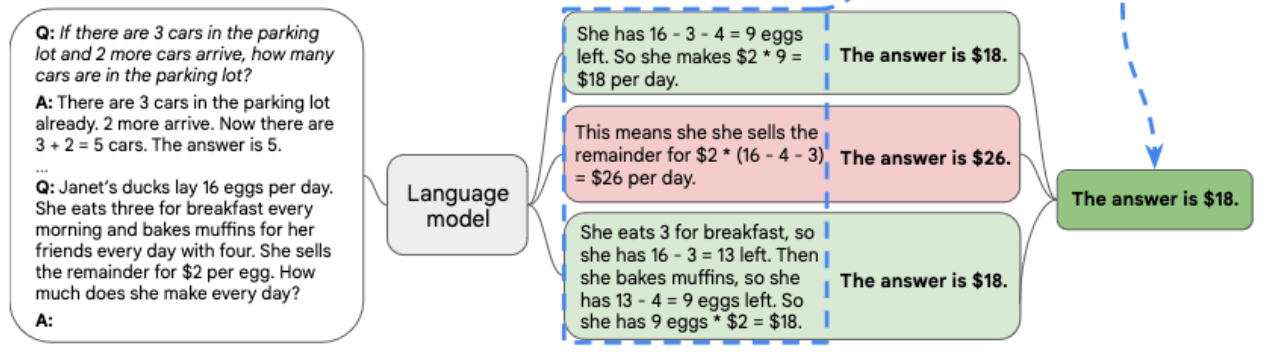# code
-->

<img src="images/self_consistency/algorithm.png"  height=250/>

## Demo

In [4]:
#question='''Q: Alex had 18 cars, then doubled how many cars he had, then lost one-sixth of the cars, and finally gained one more. How many cars does he have at the end?
#A: '''
question='''Q: Kyle bought last year's best-selling book for $21. Next year it will cost 35% more. How much will it cost next year?
A: '''

In [5]:
single = Completion.create(
    prompt=(few_shot_prompt + question),
    model="davinci-002",
    max_tokens=75,
    n=1,
    temperature=0.0,
    stop="Q: ")

# Result string
single['choices'][0]['text']

'35% more means 35% + 100% = 135%. So the price will be 21 * 1.35 = 28.05. The answer is 28.05.\n'

In [6]:
completions = Completion.create(
    prompt=(few_shot_prompt + question),
    model="davinci-002",
    temperature=.5,
    max_tokens=75,
    n=40,
    stop="Q: ")

for response in completions['choices'][:3]:
    print('=====\n' + response['text'])

=====
21 dollars was the price for last year's best-selling book. Next year it will be 35% more. 1.35 * 21 = 28.35. The answer is 28.35.

=====
35% means 0.35. Last year's book cost $21. 35% more means 0.35 * 21 = 7.35. So the new price will be 21 + 7.35 = 28.35. The answer is 28.35.

=====
35% of 21 is 21 * 35% / 100 = 7.35. So 35% more will cost 21 + 7.35 = 28.35. The answer is 28.35.



In [7]:
import re

# Extract regex: "The answer is (<answer>)"

pattern = re.compile(r'answer is ([^\s]+)')
answers = []
for response in completions['choices']:
    matches = pattern.findall(response['text'])
    if len(matches) > 0:
        answers.append(matches[0])

from collections import Counter
ctr = Counter(answers)
ctr.most_common(5)

[('28.35.', 17), ('28.05.', 6), ('$28.05.', 2), ('28.15.', 1), ('7.05.', 1)]

## Parameters
Main results: take 40 samples ("reasoning paths"), temperature=0.5, top_k=40

But results compatible with many sampling strategies

# Results
Achieved improvement on every model tried, including very large models like GPT-3 and PaLM-540B (540 billion parameters).

## Specific example of improvement

For instance, in the table below we see davinci-002 took on the  GSM8K benchmark and self-consistency improved it from ~60% to ~78% accuracy, 17.9 percentage point improvement in accuracy.

<img src="images/self_consistency/results_table.png" height="250" />

## Example of incorrect vs correct answer

Here we can see another specific example of a question getting an incorrect answer from greedy decoding and fixed by self-consistency sampling.
    
<img src="images/self_consistency/example_greedy_vs_sampling.png" height="250"/>


# Outperformed other tested approaches 
* Multimodel ensemble - outperformed ensemble of only 3 models.
* Ensemble of prompts (re-order examples, ensemble of wholly different prompts)
* Beam search
  * Note: Among sampled results, correct answers did not have significantly more probability than incorrect ones, and beam search relies on picking the sequence with best total probability at the end

# Effects of parameters
### Number of reasoning paths
Performance saturated at 10 paths.
<img src="images/self_consistency/improvement_over_number_of_samples.png" height=250/>

### Varied sampling methods

Tried top_p, and also varying temperature and top_k.
<img src="images/self_consistency/effects_of_sampling_strategies.png" height=250/>

Beam search works as a sampling method, but has less diversity than other methods, and underperforms

# Observations
Larger effect for larger model size
<img src="images/self_consistency/effects_of_model_size.png" height=250/>

Consistency percentage is a good confidence indicator
<img src="images/self_consistency/consistency_as_confidence_measure.png" height=250/>

Trade-off: one-time compute during training vs permanent 10x or more compute cost increase at inference